# Inverted Pendulum DQN - Grid Search

This script is an extension to the inverted pendulum DQN algorithm in inv_pend.ipynb. This scripts automates the grid search in a hyperparameter space to explore the best performance of DQN.





In [1]:
# TODO
# - [ ] Package functions related to the experiment in a `GridSearch` class
#     - **Attributes:**
#         - Hyperparameters - model arch, lr , buffer_size, min_replay_szie, target_update_freq, gamma, eps_start, eps_end, eps_decay, episode_train, and batch_size
#         - The simulation environment
#     - **Methods:** 
#         - `create_directory()` - for storing the training results for each hyperparameter configuration
#         - `eps_greedy_policy()` - for picking out an action given the observation
#         - `DQN_train()` - for training a Q network from simulation

# - [ ] Save the model (parameters and architecture) following training in the grid search

In [2]:
import random                       # To draw a random batch of samples form the replay buffer
import gymnasium as gym
import torch
from torch import nn
import torch.optim as optim
from torchsummary import summary

import numpy as np
import matplotlib.pyplot as plt

import os                                               # For saving models and training results
from datetime import datetime                           # For creating the directory of each training run
import json                                             # For storing training parameters during each run
import re                                               # For checking the latest trial #
from contextlib import redirect_stdout

from collections import deque       # replay buffer is a double ended queue that allows elements to be added either to the end or the start

# Setup

In [3]:
class QNet_MLP(nn.Module):
    ''' A QNetwork class that dynamically initialize an MLP Q Net'''
    def __init__(self,input_dim,output_dim,hidden_layer = [64,32]):
        super().__init__()

        self.layers = nn.ModuleList()
        self.input_dim = input_dim
        self.output_dim = output_dim

        for size in hidden_layer:
            self.layers.append(nn.Linear(self.input_dim, size))
            self.input_dim = size
        
        self.layers.append(nn.Linear(self.input_dim,self.output_dim))
    
    def forward(self, input_data):
        for layer in self.layers[:-1]:
            input_data = torch.relu(layer(input_data))
        return self.layers[-1](input_data)

In [4]:
%%script test --no-raise-error
class QNet_MLP(nn.Module):
    ''' A QNetwork class that dynamically initializes an MLP Q Network. '''
    def __init__(self, input_dim, output_dim, hidden_layer=[64, 32]):
        super().__init__()
        
        # Create a list of layers: input -> hidden -> activation -> hidden -> activation -> output
        layers = []
        # 
        # Add hidden layers with activations
        prev_dim = input_dim
        
        for size in hidden_layer:
            layers.append(nn.Linear(prev_dim, size))  # Linear layer
            layers.append(nn.ReLU())                  # Activation
            prev_dim = size
        
        # Output layer
        layers.append(nn.Linear(prev_dim, output_dim))  # Output layer
        
        # Use nn.Sequential for clean layer handling
        self.network = nn.Sequential(*layers)
    
    def forward(self, input_data):
        return self.network(input_data)

Couldn't find program: 'test'


In [5]:
%%script test --no-raise-error
# Define Q-network architecture statically
class QNetwork(nn.Module):
    ''' A QNetwork class that statically initialize an MLP neural Q network with two hidden layers, each with 128 nodes '''
    def __init__(self, input_dim, output_dim, hidden_layer: list):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, output_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)                       # The regression output are the state values of Q(s,a=left) and Q(s,a=right)

Couldn't find program: 'test'


In [6]:
def create_directory(model_id: int,
                     lr: float, 
                     gamma: float,
                     epsilon_decay: int,
                     batch_size: int, 
                     buffer_size: int,
                     target_update_freq: int):
    ''' Function that creates directory to save model state_dict, architecture, training configurationi and history

    Parameters: 
    ------------
    (hyperparameters for differentiating between different directory)
    
    lr : float
        the learning rate to optimize the Q network
    gamma : float 
        the discount rate in Q learning
    epsilon_decay : integer
        the amount of episode over which the exploratory rate (epsilon) decays
    batch_size : integer
        number of experience drawn from replay buffer to train the behaviour network
    buffer_size : integer
        the number of samples in the replay buffer at a time
    target_udpate_freq : integer
        the amount of step count during the training process before updating the target Q net (loading the parameters of the behaviour net onto the target Q Net)
    

    Returns
    ------------
    name_codified : str
        the shortened name for the current experiment 
    OUTPUT_DIR : path
        the directory to which the trainin results and model (state_dict and architecture) are saved

    '''
    
    timestamp = datetime.now().strftime("%y%m%d_%H%M")
    BASE_DIR = os.getcwd()
    RESULT_DIR = os.path.join(BASE_DIR, "inv_pend_results")

    existing_runs = [d for d in os.listdir(RESULT_DIR) if os.path.isdir(os.path.join(RESULT_DIR,d))]
    run_numbers = [int(re.search(r'run_(\d{5})',d).group(1)) for d in existing_runs if re.match(r'run_\d{5}',d)]
    trial_number = max(run_numbers,default=-1)+1

    name_codified = f"run_{trial_number:05d}"
    hyperparam_codified = f"{timestamp}_{model_id}_{lr}_{gamma}_{epsilon_decay}_{batch_size}_{buffer_size}_{target_update_freq}"

    OUTPUT_DIR = os.path.join(BASE_DIR,"inv_pend_results",name_codified)
    os.makedirs(OUTPUT_DIR, exist_ok=True)      # Create the directory

    
    # Store the training configs in JSON file
    training_params = {
        'model_id': model_id,
        'lr': lr,
        'gamma': gamma,
        'epsilon_decay': epsilon_decay,
        'batch_size': batch_size,
        'buffer_size': buffer_size,
        'target_update_freq': target_update_freq
    }

    # Append the mapping from run # to hyperparameter configuration in a file in inv_pend_results
    trial_to_param_path = os.path.join(RESULT_DIR,'trial_to_param.json')
    if os.path.exists(trial_to_param_path):
        with open(trial_to_param_path, "r") as f:
            data = json.load(f)
    else:
        data = {name_codified: []}
    
    data[name_codified] = hyperparam_codified

    with open(trial_to_param_path, "w") as f:
        json.dump(data, f, indent=2)

    # Store training parameters in each run 
    param_path = os.path.join(OUTPUT_DIR, "param_config.json")
    with open(param_path, "w") as f:
        json.dump({"parameters": training_params}, f, indent=2)

    return name_codified, hyperparam_codified, OUTPUT_DIR

In [7]:
def eps_greedy_policy(env, obs, epsilon: float, q_network: QNet_MLP):
    ''' Function to take an action according to an epsilon-greedy policy and a Q-network'''
    if np.random.random() < epsilon:
        action = env.action_space.sample()
    else:
        with torch.no_grad():
            state_tensor = torch.FloatTensor(obs).unsqueeze(0)
            q_values = q_network(state_tensor)
            action = q_values.argmax().item()

    return action

In [ ]:
def policy_eval(env_test, q_network, n_episode_test = 500, seed = None):
    ''' Assess the average reward when following a q_network '''
    
    total_reward = 0
    for i in range(n_episode_test):
        obs,_ = env_test.reset(seed=seed)
        done = False
        eps_reward = 0

        while not done:                 # Step thorugh the episode
            action = eps_greedy_policy(env_test, obs, 0, q_network)
            next_obs, reward, term, trunc, _ = env_test.step(action)

            eps_reward += reward

            obs = next_obs
            done = term or trunc

        total_reward += eps_reward

    return total_reward / n_episode_test
    

In [ ]:
def DQN_train(env,
              q_network: QNet_MLP, 
              target_net: QNet_MLP, 
              optimizer, 
              replay_buffer,
              target_update_freq,
              gamma,
              eps_start,
              eps_end,
              eps_decay,
              episode_train,
              batch_size, 
              seed = 42):
    ''' Function to train a policy for a set of hyperparameters '''

    msg = "Training ended successfully"

    reward_history = np.zeros(episode_train)
    epsilon = eps_start
    step_count = 0
    episode = 0
    target_network_update_count = 0

    best_rewards = 50
    consecutive_count = 0           # Number of consecutive episodes where performance exceeds a threshold
    train_terminated = False
    progress_dict = {}              # Dictionary of improvement throughout training

    val_dict = {}                   # Dictionary of validation results for episode with rewards excedding a threshold
    episosde_val = 1000

    performance_crit = False
    while not train_terminated:     # Experiment level - loop through episodes
        obs, _ = env.reset(seed=seed)
        eps_rewards = 0
    
        while True:                 # Episode level - loop through steps
            action = eps_greedy_policy(env, obs, epsilon, q_network)

            # Interact with the environment
            next_obs, reward, term, trunc, _ = env.step(action)
            done = term or trunc
            replay_buffer.append((obs, action, reward, next_obs, done))
            obs = next_obs
            eps_rewards += reward
            step_count += 1

            # Train the Q-net using a batch of samples from the experience replay
            if len(replay_buffer) >= batch_size:
                batch = random.sample(replay_buffer, batch_size)
                states, actions, rewards, next_states, dones = zip(*batch)

                states = torch.FloatTensor(np.array(states))            # Shape of (BATCH_SIZE, 4). Data structure of [[p1 v1 theta1 dtheta1], [p2 v2 theta2 dtheta2], ...]
                actions = torch.LongTensor(actions).unsqueeze(1)        # Must unsqueeze to have shape (BATCH_SIZE, 1). From [a1, a2, ...] to [[a1], [a2], ... [a_BATCH_SIZE]]
                rewards = torch.FloatTensor(rewards).unsqueeze(1)
                next_states = torch.FloatTensor(np.array(next_states))
                dones = torch.FloatTensor(dones).unsqueeze(1)
                
                # Compute targets using target network Q(s',a',w_i^-)
                with torch.no_grad():
                    target_q_values = target_net(next_states)       # Find a batch of Q(s',a',w_i^-) from the batch of next_states
                    max_target_q_values = target_q_values.max(dim=1, keepdim=True)[0]
                    targets = rewards + gamma * max_target_q_values * (1 - dones)       # (1-dones) to avoid over estimating the value of terminal states. The target should only be the reward in the terminal states
            
                # Compute the current Q values for the actions taken Q(s,a,w_i)
                q_values = q_network(states).gather(1, actions)         # obtain the q_values associated to the actual action taken in each sample

                # Update the parameters of the behaviour q_network
                loss = nn.MSELoss()(q_values, targets)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            # Periodically update the target network by loading the weights from the behavior network
            if step_count % target_update_freq == 0:
                target_network_update_count += 1
                target_net.load_state_dict(q_network.state_dict())

            if done:        # End of a training episode
                break

        # Decay epsilon after an episode
        epsilon = max(eps_end, epsilon - (eps_start - eps_end)/eps_decay)

        reward_history[episode] = eps_rewards
        # print(f"Episode {episode:5d}: Total reward = {eps_rewards:5.1f}, Epsilon = {epsilon:.3f}, Step count = {step_count:5d}, Target update count = {target_network_update_count:3d}")
        # print(f"Average reward {sum(reward_history[:episode])/(episode+1):.2f}")

        
        # Progress report
        if eps_rewards - best_rewards > 10:     # print out the episode with the current best performance
            progress_dict[episode] = eps_rewards
            best_rewards = eps_rewards

            # print(f"\nImproved reward of {best_rewards:4.0f} in episode {episode:5d}")
        
        if episode % 10 == 0:                   # print progress periodically
            print(f"Episode {episode:5d}: Total reward = {eps_rewards:5.1f}, Epsilon = {epsilon:.3f}, Step count = {step_count:5d}, Target update count = {target_network_update_count:3d}", end = "\r")

        # Monitor the performance during training for signs of good performance
        if eps_rewards >= 400:
            consecutive_count += 1
        else:
            consecutive_count = 0

        # Performance criteria
        if consecutive_count >= 1:
            performance_crit = True 
            msg = f"Early termination at episode {episode:5d} - desired performance reached"


        episode += 1

        # Checking for early training termination or truncation
        train_terminated = (episode >= episode_train) or (performance_crit)
    print("\n")
    return reward_history, progress_dict, msg


In [10]:
def EMA_filter(reward: list, alpha):
    output = np.zeros(len(reward)+1)
    output[0] = reward[0]
    for idx, item in enumerate(reward):
        output[idx+1] = (1 - alpha) * output[idx] + alpha * item
    
    return output

def plot_reward_hist(reward_history: list, save_path, alpha = 0.1):
    n_episodes= len(reward_history)
    episodes = range(n_episodes)
    filtered_reward_hist = EMA_filter(reward_history, alpha)

    plt.figure(figsize=(20,6))
    plt.plot(episodes, reward_history[:n_episodes], color = "blue")
    plt.plot(episodes, filtered_reward_hist[:n_episodes], color = "red")
    plt.title('Total reward per episode')
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.legend(['Total reward','Filtered reward'])

    plt.tight_layout()
    plt.savefig(os.path.join(save_path,'reward_history.png'))
    plt.show()

In [11]:
%%script test --no-raise-error
# Test creating the Q network with dynamic hidden layer when specifying the list of hidden nodes

Q_net = QNet_MLP(obs_space,action_space,[64,32])
summary(Q_net, (obs_space,))

Couldn't find program: 'test'


In [12]:
%%script test --no-raise-error
BASE_DIR = os.getcwd()
RESULTS_DIR = os.path.join(BASE_DIR,"inv_pend_results")
os.makedirs(RESULTS_DIR, exist_ok = True)

existing_runs = [d for d in os.listdir(RESULTS_DIR) if os.path.isdir(os.path.join(RESULTS_DIR,d))]
existing_runs

Couldn't find program: 'test'


# Parameter Set

In [13]:
model_registry = {
    'DQN_MLP_v0': {
        'class': QNet_MLP,
        'config': [64,32]
    },
    'DQN_MLP_v1': {
        'class': QNet_MLP,
        'config': [32,32]
    },
    'DQN_MLP_v2': {
        
        'class': QNet_MLP,
        'config': [32,16]
    },
    'DQN_MLP_v3': {
        'class': QNet_MLP,
        'config': [16,16]
    }
}

The block below is used for testing the model creation automation (Uncomment the first line to run the test)

In [14]:
%%script test --no-raise-error
for model in model_registry:
    Q_net = QNet_MLP(obs_space, action_space, model_registry[model]['config'])
    # print(model_registry[model]['config'])
    print(Q_net)

Couldn't find program: 'test'


In [15]:
# # Actual parameter grid
# param_grid = {
#     'MODEL': [model for model in model_registry],
#     'LR': [5e-4, 1e-3, 5e-3, 1e-2],
#     "BUFFER_SIZE": [1000, 5000, 10000],
#     "MIN_REPLAY_SIZE": [1000],
#     "TARGET_UPDATE_FREQ": [1000, 5000, 10000],

#     "GAMMA": [0.90, 0.95, 0.98],
#     "EPSILON_START": [1.0],
#     "EPSILON_END": [0.1],
#     "EPSILON_DECAY": [1000, 5000, 10000],

#     "EPISODE_TRAIN": [5000],                # training truncation criteria
#     "BATCH_SIZE": [32, 64, 128]
# }

# success_criteria = 450                      #


In [16]:
# Simplified param grid to test functionality
param_grid = {
    # 'MODEL': [model for model in model_registry],
    'MODEL': ['DQN_MLP_v0', 'DQN_MLP_v1'],
    'LR': [1e-3],
    "BUFFER_SIZE": [5000],
    "MIN_REPLAY_SIZE": [1000],
    "TARGET_UPDATE_FREQ": [1000],

    "GAMMA": [0.95],
    "EPSILON_START": [1.0],
    "EPSILON_END": [0.1],
    "EPSILON_DECAY": [5000],

    "EPISODE_TRAIN": [5000],                # training truncation criteria
    "BATCH_SIZE": [32]
}

success_criteria = 450                      #


# Grid Search

Using itertools to loop through each combination of hyperparameters

Trial 1/2 - model DQN_MLP_v0, lr=0.001, buffer=5000, target_freq=1000, gamma=0.95, eps_decay=5000, batch_size=32
Episode  2490: Total reward =  98.0, Epsilon = 0.552, Step count = 107005, Target update count = 107

Runtime - 180.444
Performance improved to   62 units of rewards in episode    49
Performance improved to   76 units of rewards in episode   305
Performance improved to  103 units of rewards in episode   397
Performance improved to  135 units of rewards in episode   812
Performance improved to  151 units of rewards in episode  1441
Performance improved to  177 units of rewards in episode  1452
Performance improved to  195 units of rewards in episode  1552
Performance improved to  220 units of rewards in episode  1840
Performance improved to  251 units of rewards in episode  1917
Performance improved to  319 units of rewards in episode  2273
Performance improved to  453 units of rewards in episode  2497
Early termination - desired performance reached


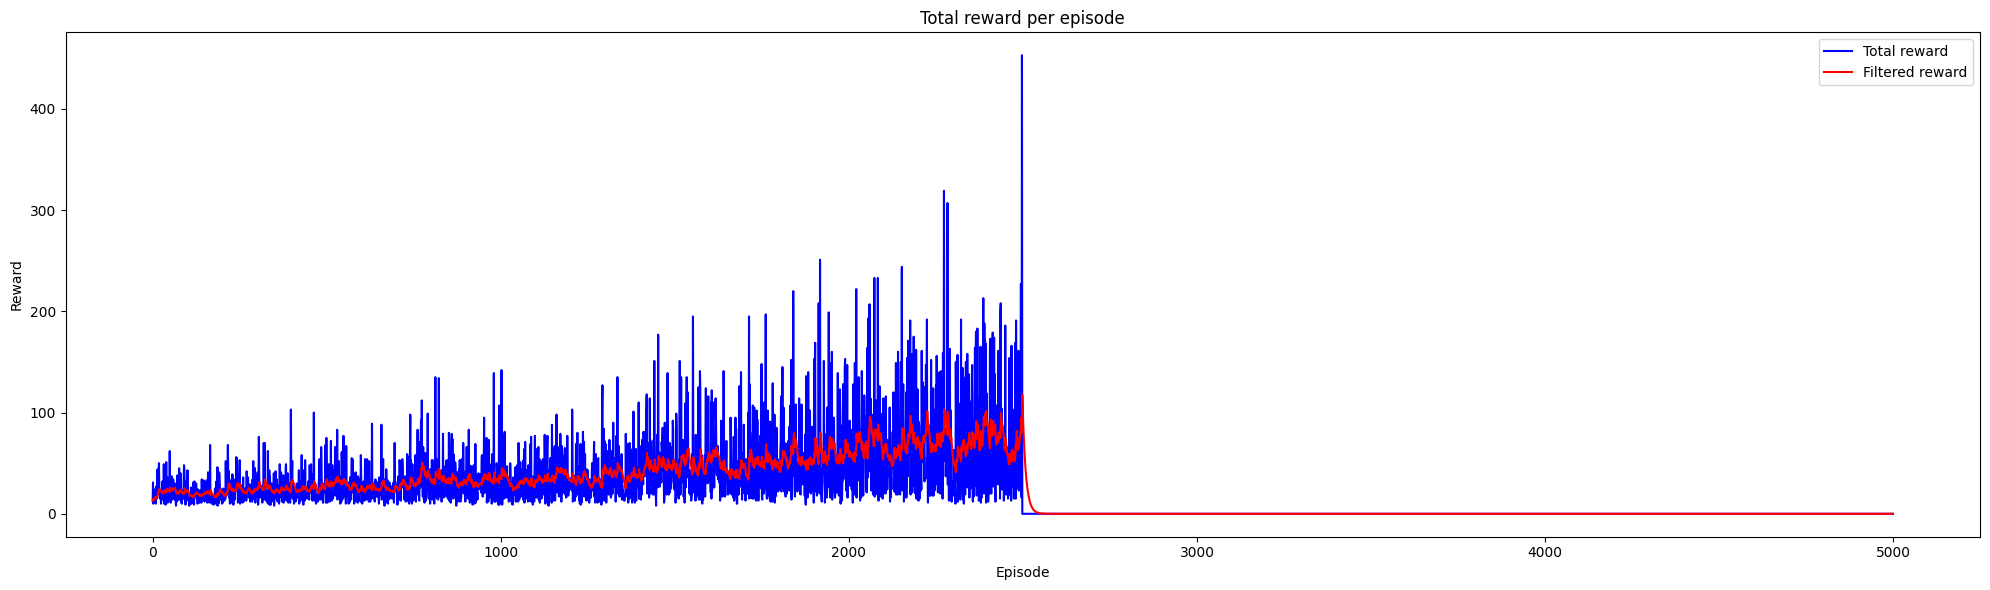

Trial 2/2 - model DQN_MLP_v1, lr=0.001, buffer=5000, target_freq=1000, gamma=0.95, eps_decay=5000, batch_size=32
Episode  3910: Total reward = 105.0, Epsilon = 0.296, Step count = 222641, Target update count = 222

Runtime - 403.821
Performance improved to   64 units of rewards in episode     3
Performance improved to   78 units of rewards in episode    98
Performance improved to  108 units of rewards in episode   557
Performance improved to  121 units of rewards in episode   874
Performance improved to  139 units of rewards in episode   964
Performance improved to  175 units of rewards in episode  1116
Performance improved to  239 units of rewards in episode  1668
Performance improved to  250 units of rewards in episode  2068
Performance improved to  264 units of rewards in episode  2251
Performance improved to  307 units of rewards in episode  2724
Performance improved to  377 units of rewards in episode  3884
Performance improved to  456 units of rewards in episode  3912
Early termi

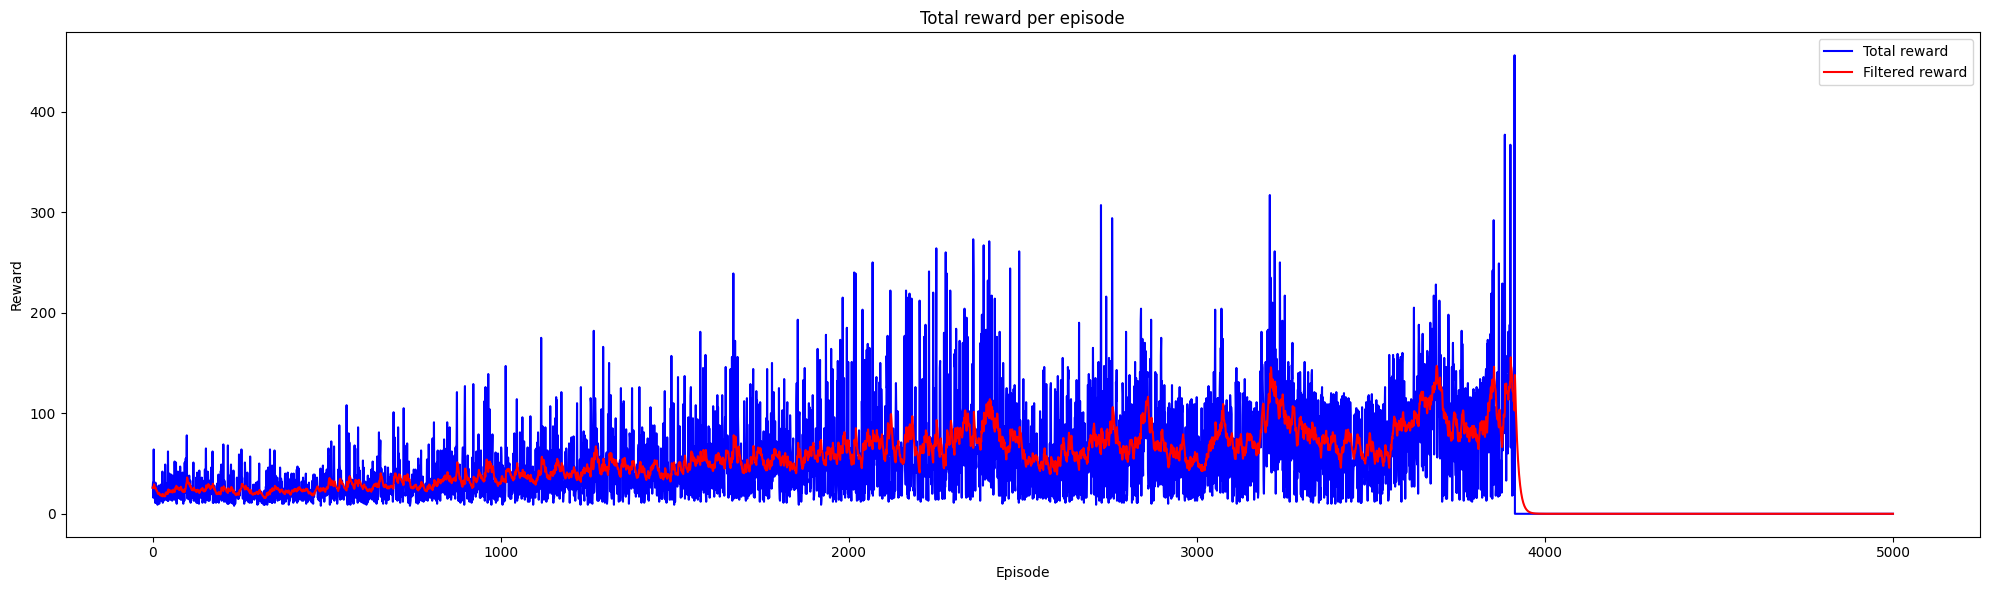

In [ ]:
import itertools
import time
keys, values = zip(*param_grid.items())
# keys, values = param_grid.keys(), param_grid.values()
num_config = len(list(itertools.product(*values)))

# Set fixed seed
seed = 42
np.random.seed(seed); random.seed(seed); torch.manual_seed(seed)

for idx, v in enumerate(itertools.product(*values)):

    # Unpacking the hyperparameter configurations
    config = dict(zip(keys,v))
    MODEL_NAME = config['MODEL']
    MODEL_CLASS = model_registry[config['MODEL']]['class']
    MODEL_CONFIG = model_registry[config['MODEL']]['config']
    match = re.search(r'v\d+',MODEL_NAME)
    MODEL_ID = match.group(0) if match else 404

    LR = config['LR']
    BUFFER_SIZE = config['BUFFER_SIZE']
    MIN_REPLAY_SIZE = config['MIN_REPLAY_SIZE']
    TARGET_UPDATE_FREQ = config['TARGET_UPDATE_FREQ']
    GAMMA = config['GAMMA']
    EPS_START = config['EPSILON_START']
    EPS_END = config['EPSILON_END']
    EPS_DECAY = config['EPSILON_DECAY']
    EPISODE_TRAIN = config['EPISODE_TRAIN']
    BATCH_SIZE = config['BATCH_SIZE']


    # Re-initialize the environment
    env = gym.make('CartPole-v1')
    obs,_ = env.reset(seed=seed)

    obs_space = env.observation_space.shape[0]
    action_space = env.action_space.n


    # Re-initialize the NN models
    Q_net = MODEL_CLASS(obs_space,action_space,MODEL_CONFIG)
    target_net = MODEL_CLASS(obs_space,action_space,MODEL_CONFIG)
    target_net.load_state_dict(Q_net.state_dict())
    target_net.eval()

    optimizer = optim.SGD(Q_net.parameters(), lr = LR)
    # optimizer = optim.Adam(Q_net.parameters(), lr = LR)

    # Re-initialize and pre-fill the replay buffer
    replay_buffer = deque(maxlen = BUFFER_SIZE)
    
    obs, _ = env.reset()
    for _ in range(MIN_REPLAY_SIZE):
        action = env.action_space.sample()
        next_obs, reward, term, trunc, _ = env.step(action)
        done = term or trunc

        replay_buffer.append((obs, action, reward, next_obs, done))
        obs = next_obs if not done else env.reset()[0]

    # Create the directory to store results
    _, _, save_path = create_directory(MODEL_ID,LR,GAMMA,EPS_DECAY,BATCH_SIZE,BUFFER_SIZE,TARGET_UPDATE_FREQ)

    print(f'Trial {idx+1}/{num_config} - model {MODEL_NAME}, lr={LR}, buffer={BUFFER_SIZE}, target_freq={TARGET_UPDATE_FREQ}, gamma={GAMMA}, eps_decay={EPS_DECAY}, batch_size={BATCH_SIZE}')
    # Train the DQN with the given hyperparameter configuration
    start_time = time.time()
    reward_history, progress_dict, msg = DQN_train(env, Q_net, target_net,optimizer,replay_buffer,
                                                    TARGET_UPDATE_FREQ,
                                                    GAMMA,
                                                    EPS_START,
                                                    EPS_END,
                                                    EPS_DECAY,
                                                    EPISODE_TRAIN,
                                                    BATCH_SIZE,
                                                    seed=seed)
    end_time = time.time()
    print(f"Runtime - {end_time - start_time:.3f}")

    # Print out training improvement
    for episode, reward in progress_dict.items():
        print(f"Performance improved to {reward:4.0f} units of rewards in episode {episode:5d}")

    print(msg)
    
    # Display and save the reward history in current trial folderr 
    plot_reward_hist(reward_history, save_path)

env.close()

In [18]:

for episode, reward in progress_dict.items():
    print(f"Performance improved to {reward:4.0f} units of rewards in episode {episode:5d}")

Performance improved to   64 units of rewards in episode     3
Performance improved to   78 units of rewards in episode    98
Performance improved to  108 units of rewards in episode   557
Performance improved to  121 units of rewards in episode   874
Performance improved to  139 units of rewards in episode   964
Performance improved to  175 units of rewards in episode  1116
Performance improved to  239 units of rewards in episode  1668
Performance improved to  250 units of rewards in episode  2068
Performance improved to  264 units of rewards in episode  2251
Performance improved to  307 units of rewards in episode  2724
Performance improved to  377 units of rewards in episode  3884
Performance improved to  456 units of rewards in episode  3912
